<a href="https://colab.research.google.com/github/martinmwarangu/Pyspark_Msc/blob/main/ChiSquare_LargeData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=0cd19a326cda8b9475e8a9a6fab0cff46eb88fdfdb5d0f15ab181d03b0415329
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import ChiSqSelector, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf


spark = SparkSession \
    .builder \
    .appName("Python Spark ML basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = spark.read.csv('/content/drive/MyDrive/Data/diabetes_big.csv',inferSchema=True, header =True)

In [6]:
# Optional, if we want to impute missing values
# Fill null values with column means
for column in df.columns:
    mean_value = df.select(mean(col(column))).collect()[0][0]
    df = df.na.fill(mean_value, subset=[column])

In [7]:
df.columns

['HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'DiffWalk',
 'Sex',
 'Age',
 'Education',
 'Income',
 'Diabetes']

In [8]:
df.describe().select("Age","Income","Education","Sex").show()

+-----------------+-----------------+------------------+------------------+
|              Age|           Income|         Education|               Sex|
+-----------------+-----------------+------------------+------------------+
|           253680|           253680|            253680|            253680|
|8.032119205298013|6.053874960580258| 5.050433617155472|0.4403421633554084|
|3.054220434168492|2.071147566271524|0.9857741757276529|0.4964291631185041|
|                1|                1|                 1|                 0|
|               13|                8|                 6|                 1|
+-----------------+-----------------+------------------+------------------+



In [9]:
df.describe().select("Diabetes").show()

+-------------------+
|           Diabetes|
+-------------------+
|             253680|
|0.29692131819615264|
| 0.6981597284091046|
|                  0|
|                  2|
+-------------------+



In [10]:

df.show(5)

+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+--------+
|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|Diabetes|
+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+--------+
|     1|       1|        1| 40|     1|     0|                   0|           0|     0|      1|                0|            1|          0|      5|      18|      15|       1|  0|  9|        4|     3|       0|
|     0|       0|        0| 25|     1|     0|                   0|           1|     0|      0|                0|            0|          1|      3|       0|       0|    

In [11]:
#us combine all the features in one single feature vector.
cols=df.columns
cols.remove("Diabetes")
# Let us import the vector assembler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols,outputCol="features")
# Now let us use the transform method to transform our dataset
df=assembler.transform(df)
df.select("features").show(truncate=False)

+----------------------------------------------------------------------------------------+
|features                                                                                |
+----------------------------------------------------------------------------------------+
|[1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0]|
|(21,[3,4,7,12,13,18,19,20],[25.0,1.0,1.0,1.0,3.0,7.0,6.0,1.0])                          |
|[1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0]|
|(21,[0,2,3,7,8,9,11,13,18,19,20],[1.0,1.0,27.0,1.0,1.0,1.0,1.0,2.0,11.0,3.0,6.0])       |
|[1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0] |
|[1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0] |
|(21,[0,2,3,4,11,13,15,18,19,20],[1.0,1.0,30.0,1.0,1.0,3.0,14.0,9.0,6.0,7.0])            |
|[1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0] |

In [12]:
#Standard Sclarizer
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
dataset=standardscaler.fit(df).transform(df)
dataset.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[1.0,1.0,1.0,40.0...|[2.02046952755145...|
|(21,[3,4,7,12,13,...|(21,[3,4,7,12,13,...|
|[1.0,1.0,1.0,28.0...|[2.02046952755145...|
|(21,[0,2,3,7,8,9,...|(21,[0,2,3,7,8,9,...|
|[1.0,1.0,1.0,24.0...|[2.02046952755145...|
+--------------------+--------------------+
only showing top 5 rows



In [13]:
#Train, test split
train, test = dataset.randomSplit([0.8, 0.2], seed=12345)

In [14]:
#Feature selection
# Feature selection using chisquareSelector
from pyspark.ml.feature import ChiSqSelector
#css = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect1',labelCol='Diabetes',fpr=0.03) # whose p-value is lower than some threshold
css1 = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect1',labelCol='Diabetes',numTopFeatures = 5)
train=css1.fit(train).transform(train)
test=css1.fit(test).transform(test)
test.select("Aspect1").show(10,truncate=False)


css2 = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect2',labelCol='Diabetes',numTopFeatures = 10)
train=css2.fit(train).transform(train)
test=css2.fit(test).transform(test)
test.select("Aspect2").show(10,truncate=False)

css3 = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect3',labelCol='Diabetes',numTopFeatures = 15)
train=css3.fit(train).transform(train)
test=css3.fit(test).transform(test)
test.select("Aspect3").show(10,truncate=False)


# Imp Arguments
# numTopFeatures chooses a fixed number of top features according to a chi-squared test. This is akin to yielding the features with the most predictive power.
# percentile is similar to numTopFeatures but chooses a fraction of all features instead of a fixed number.
# fpr chooses all features whose p-values are below a threshold, thus controlling the false positive rate of selection.
# By default, the selection method is numTopFeatures, with the default number of top features set to 50. The user can choose a selection method using setSelectorType.



#####################
# Additional work (optional)
#####################
# Find methods to apply other feature selection algorithms.
# FOr example, SVD, LSA, etc
# Apply at-least one more algorithm for feature selection apart from Chi^2 algorithm
# Note: PCA is not preciselfy feature selection (its a dimenionality reduction),


+------------------------------------------------+
|Aspect1                                         |
+------------------------------------------------+
|(5,[3,4],[2.4210531630584424,2.013041826529639])|
|(5,[3],[2.5723689857495953])                    |
|(5,[3],[2.5723689857495953])                    |
|(5,[3,4],[2.5723689857495953,2.013041826529639])|
|(5,[3,4],[2.5723689857495953,2.013041826529639])|
|(5,[3],[2.7236848084407477])                    |
|(5,[3],[2.7236848084407477])                    |
|(5,[3,4],[2.7236848084407477,2.013041826529639])|
|(5,[3,4],[2.7236848084407477,2.013041826529639])|
|(5,[3],[2.8750006311319005])                    |
+------------------------------------------------+
only showing top 10 rows

+---------------------------------------------------------------------------------------------------------------+
|Aspect2                                                                                                        |
+-------------------------------

In [15]:
#Building a classification model using Logistic Regression (LR)
from pyspark.ml.classification import LogisticRegression
lr1 = LogisticRegression(labelCol="Diabetes", featuresCol="Aspect1",maxIter=10)
model1=lr1.fit(train)
predict_train1=model1.transform(train)
predict_test1=model1.transform(test)
predict_test1.select("Diabetes","prediction").show(10)


lr2 = LogisticRegression(labelCol="Diabetes", featuresCol="Aspect2",maxIter=10)
model2=lr2.fit(train)
predict_train2=model2.transform(train)
predict_test2=model2.transform(test)
predict_test2.select("Diabetes","prediction").show(10)

lr3 = LogisticRegression(labelCol="Diabetes", featuresCol="Aspect3",maxIter=10)
model3=lr3.fit(train)
predict_train3=model3.transform(train)
predict_test3=model3.transform(test)
predict_test3.select("Diabetes","prediction").show(10)

+--------+----------+
|Diabetes|prediction|
+--------+----------+
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 10 rows

+--------+----------+
|Diabetes|prediction|
+--------+----------+
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 10 rows

+--------+----------+
|Diabetes|prediction|
+--------+----------+
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 10 rows

In [16]:
trainingSummary1 = model1.summary

trainingSummary2 = model2.summary

trainingSummary3 = model3.summary



In [17]:
#Evaluating the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="Diabetes")
predict_test1.select("Diabetes","rawPrediction","prediction","probability").show(5)

+--------+--------------------+----------+--------------------+
|Diabetes|       rawPrediction|prediction|         probability|
+--------+--------------------+----------+--------------------+
|       0|[3.66253554519626...|       0.0|[0.99099606243625...|
|       0|[3.73718444352800...|       0.0|[0.99204392343623...|
|       0|[3.73718444352800...|       0.0|[0.99204392343623...|
|       0|[3.62282104339375...|       0.0|[0.99042014814998...|
|       0|[3.62282104339375...|       0.0|[0.99042014814998...|
+--------+--------------------+----------+--------------------+
only showing top 5 rows



In [18]:
accuracy_model_1 = trainingSummary1.accuracy
print('acuracy_model_1 = ', accuracy_model_1)

accuracy_model_2 = trainingSummary2.accuracy
print('acuracy_model_2 = ', accuracy_model_2)

accuracy_model_3 = trainingSummary3.accuracy
print('acuracy_model_3 = ', accuracy_model_3)



acuracy_model_1 =  0.8425146043285949
acuracy_model_2 =  0.843849435036597
acuracy_model_3 =  0.8466225335185349


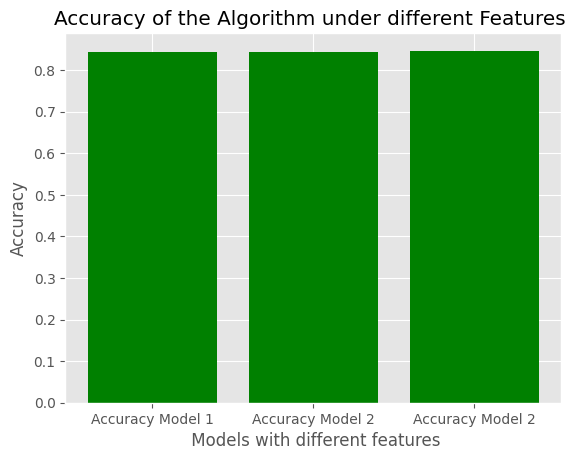

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = ['Accuracy Model 1', 'Accuracy Model 2', 'Accuracy Model 2']
accuracy = [accuracy_model_1, accuracy_model_2, accuracy_model_3]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='green')
plt.xlabel(" Models with different features")
plt.ylabel("Accuracy")
plt.title("Accuracy of the Algorithm under different Features ")

plt.xticks(x_pos, x)

plt.show()

**# SELF LEarning --Exercise, Find Precision, Recall and ROC **

In [ ]:
# SELF LEarning --Exercise, Find Precision, Recall and ROC

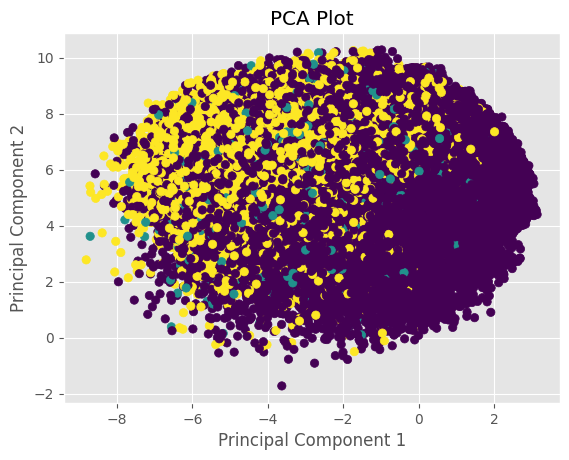

In [20]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce dimensionality to 2 dimensions
pca = PCA(k=2, inputCol="Scaled_features", outputCol="pca_features")
pca_model = pca.fit(dataset)
dataset_pca = pca_model.transform(dataset)

# Plot PCA-transformed features
pca_features = pca_model.transform(dataset).select("pca_features").collect()
pca_x = [i[0][0] for i in pca_features]
pca_y = [i[0][1] for i in pca_features]

plt.scatter(pca_x, pca_y, c=dataset.select("Diabetes").collect(), cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')
plt.show()


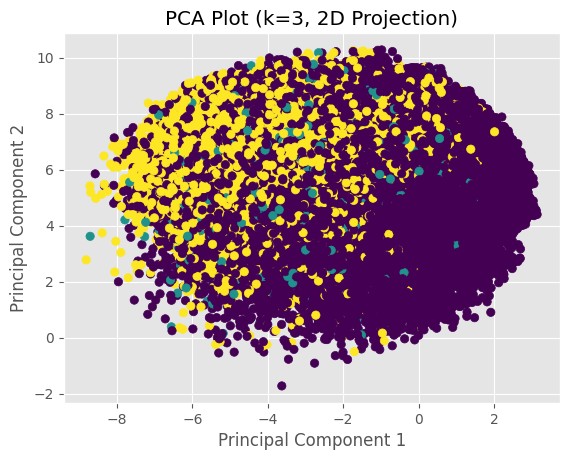

Text(0.5, 0.92, 'PCA Plot (k=3, 3D Projection)')

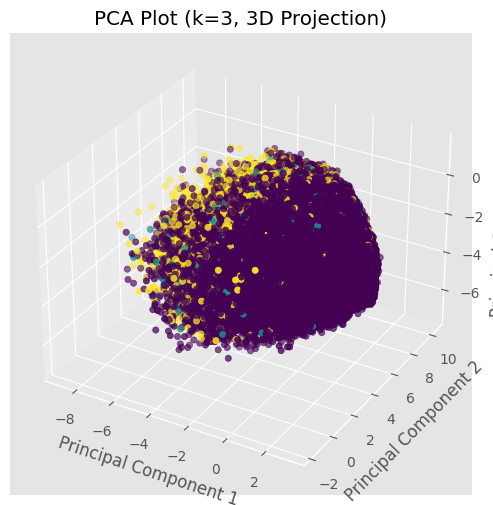

In [21]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce dimensionality to 3 dimensions
pca = PCA(k=3, inputCol="Scaled_features", outputCol="pca_features")
pca_model = pca.fit(dataset)
dataset_pca = pca_model.transform(dataset)

# Plot PCA-transformed features
pca_features = pca_model.transform(dataset).select("pca_features").collect()
pca_x = [i[0][0] for i in pca_features]
pca_y = [i[0][1] for i in pca_features]
pca_z = [i[0][2] for i in pca_features]

# Plot 2D projection of the first two principal components
plt.scatter(pca_x, pca_y, c=dataset.select("Diabetes").collect(), cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot (k=3, 2D Projection)')
plt.show()

# Plot 3D projection of all three principal components
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_x, pca_y, pca_z, c=dataset.select("Diabetes").collect(), cmap='viridis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA Plot (k=3, 3D Projection)')


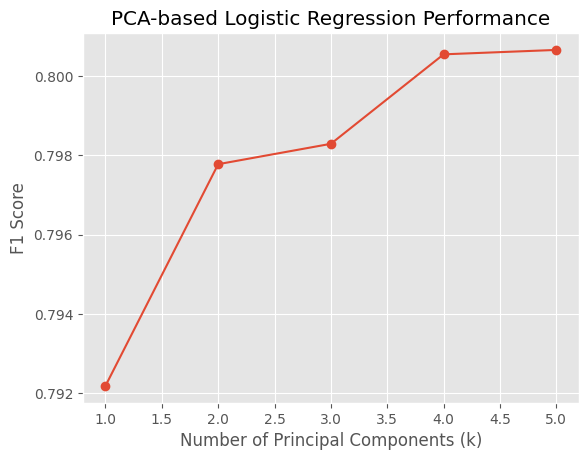

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a range of values for k
k_values = [1, 2, 3, 4, 5]

# Lists to store F1 scores for different k values
f1_scores = []

for k in k_values:
    # Apply PCA with current k value
    pca = PCA(k=k, inputCol="Scaled_features", outputCol="pca_features")
    pca_model = pca.fit(dataset)
    dataset_pca = pca_model.transform(dataset)

    # Split dataset into train and test sets
    train_pca, test_pca = dataset_pca.randomSplit([0.8, 0.2], seed=12345)

    # Train logistic regression model
    lr_pca = LogisticRegression(labelCol="Diabetes", featuresCol="pca_features", maxIter=10)
    model_lr_pca = lr_pca.fit(train_pca)

    # Make predictions on test set
    predictions_test_pca = model_lr_pca.transform(test_pca)

    # Evaluate model using F1 score
    evaluator = MulticlassClassificationEvaluator(labelCol="Diabetes", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(predictions_test_pca)

    # Store F1 score
    f1_scores.append(f1)

# Plot F1 scores for different k values
plt.plot(k_values, f1_scores, marker='o')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('F1 Score')
plt.title('PCA-based Logistic Regression Performance')
plt.grid(True)
plt.show()


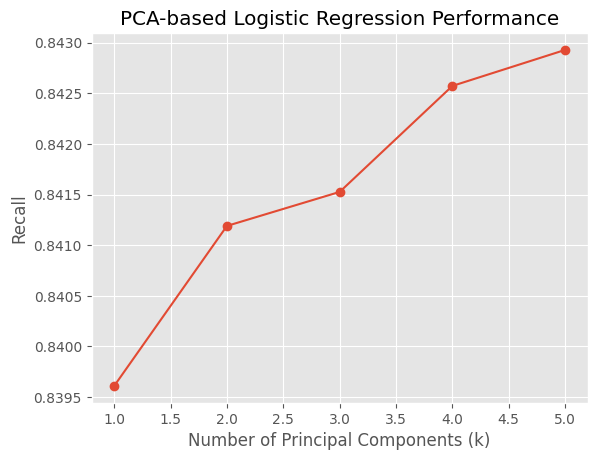

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a range of values for k
k_values = [1, 2, 3, 4, 5]

# Lists to store F1 scores for different k values
weightedRecall = []

for k in k_values:
    # Apply PCA with current k value
    pca = PCA(k=k, inputCol="Scaled_features", outputCol="pca_features")
    pca_model = pca.fit(dataset)
    dataset_pca = pca_model.transform(dataset)

    # Split dataset into train and test sets
    train_pca, test_pca = dataset_pca.randomSplit([0.8, 0.2], seed=12345)

    # Train logistic regression model
    lr_pca = LogisticRegression(labelCol="Diabetes", featuresCol="pca_features", maxIter=10)
    model_lr_pca = lr_pca.fit(train_pca)

    # Make predictions on test set
    predictions_test_pca = model_lr_pca.transform(test_pca)

    # Evaluate model using weightedRecall score
    evaluator = MulticlassClassificationEvaluator(labelCol="Diabetes", predictionCol="prediction", metricName="weightedRecall")
    Recall = evaluator.evaluate(predictions_test_pca)

    # Store Recall
    weightedRecall.append(Recall)

# Plot F1 scores for different k values
plt.plot(k_values, weightedRecall, marker='o')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Recall')
plt.title('PCA-based Logistic Regression Performance')
plt.grid(True)
plt.show()


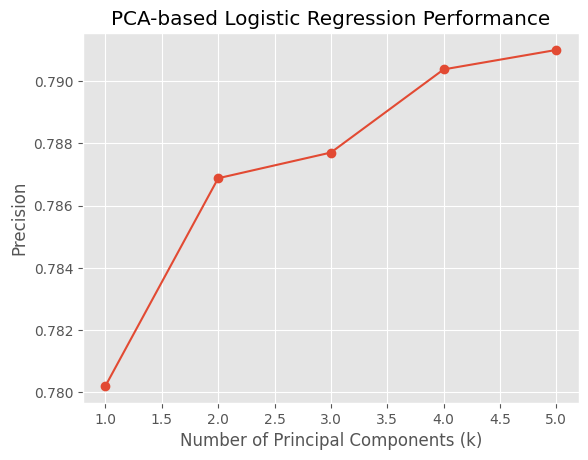

In [26]:
# precision
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a range of values for k
k_values = [1, 2, 3, 4, 5]

# Lists to store F1 scores for different k values
weightedPrecision = []

for k in k_values:
    # Apply PCA with current k value
    pca = PCA(k=k, inputCol="Scaled_features", outputCol="pca_features")
    pca_model = pca.fit(dataset)
    dataset_pca = pca_model.transform(dataset)

    # Split dataset into train and test sets
    train_pca, test_pca = dataset_pca.randomSplit([0.8, 0.2], seed=12345)

    # Train logistic regression model
    lr_pca = LogisticRegression(labelCol="Diabetes", featuresCol="pca_features", maxIter=10)
    model_lr_pca = lr_pca.fit(train_pca)

    # Make predictions on test set
    predictions_test_pca = model_lr_pca.transform(test_pca)

    # Evaluate model using Precision
    evaluator = MulticlassClassificationEvaluator(labelCol="Diabetes", predictionCol="prediction", metricName="weightedPrecision")
    Precision = evaluator.evaluate(predictions_test_pca)

    # Store F1 score
    weightedPrecision.append(Precision)

# Plot F1 scores for different k values
plt.plot(k_values, weightedPrecision, marker='o')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Precision')
plt.title('PCA-based Logistic Regression Performance')
plt.grid(True)
plt.show()


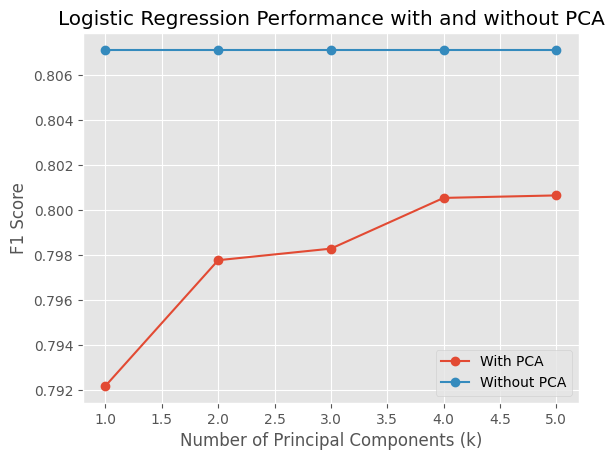

In [23]:
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# Define a range of values for k
k_values = [1, 2, 3, 4, 5]

# Lists to store F1 scores for PCA and non-PCA cases
f1_scores_pca = []
f1_scores_no_pca = []

# Train logistic regression model without PCA
train, test = dataset.randomSplit([0.8, 0.2], seed=12345)
lr_no_pca = LogisticRegression(labelCol="Diabetes", featuresCol="Scaled_features", maxIter=10)
model_lr_no_pca = lr_no_pca.fit(train)

for k in k_values:
    # Apply PCA with current k value
    pca = PCA(k=k, inputCol="Scaled_features", outputCol="pca_features")
    pca_model = pca.fit(dataset)
    dataset_pca = pca_model.transform(dataset)

    # Split dataset into train and test sets
    train_pca, test_pca = dataset_pca.randomSplit([0.8, 0.2], seed=12345)

    # Train logistic regression model with PCA
    lr_pca = LogisticRegression(labelCol="Diabetes", featuresCol="pca_features", maxIter=10)
    model_lr_pca = lr_pca.fit(train_pca)

    # Make predictions on test set with PCA
    predictions_test_pca = model_lr_pca.transform(test_pca)

    # Evaluate model with PCA
    evaluator_pca = MulticlassClassificationEvaluator(labelCol="Diabetes", predictionCol="prediction", metricName="f1")
    f1_pca = evaluator_pca.evaluate(predictions_test_pca)
    f1_scores_pca.append(f1_pca)

    # Make predictions on test set without PCA
    predictions_test_no_pca = model_lr_no_pca.transform(test)

    # Evaluate model without PCA
    evaluator_no_pca = MulticlassClassificationEvaluator(labelCol="Diabetes", predictionCol="prediction", metricName="f1")
    f1_no_pca = evaluator_no_pca.evaluate(predictions_test_no_pca)
    f1_scores_no_pca.append(f1_no_pca)

# Plot F1 scores for different k values
plt.plot(k_values, f1_scores_pca, marker='o', label='With PCA')
plt.plot(k_values, f1_scores_no_pca, marker='o', label='Without PCA')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('F1 Score')
plt.title('Logistic Regression Performance with and without PCA')
plt.legend()
plt.grid(True)
plt.show()


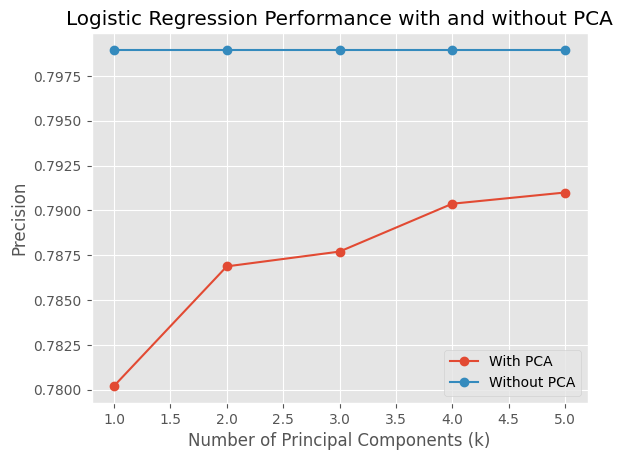

In [27]:
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# Define a range of values for k
k_values = [1, 2, 3, 4, 5]

# Lists to store F1 scores for PCA and non-PCA cases
weightedPrecision_pca = []
weightedPrecision_no_pca = []

# Train logistic regression model without PCA
train, test = dataset.randomSplit([0.8, 0.2], seed=12345)
lr_no_pca = LogisticRegression(labelCol="Diabetes", featuresCol="Scaled_features", maxIter=10)
model_lr_no_pca = lr_no_pca.fit(train)

for k in k_values:
    # Apply PCA with current k value
    pca = PCA(k=k, inputCol="Scaled_features", outputCol="pca_features")
    pca_model = pca.fit(dataset)
    dataset_pca = pca_model.transform(dataset)

    # Split dataset into train and test sets
    train_pca, test_pca = dataset_pca.randomSplit([0.8, 0.2], seed=12345)

    # Train logistic regression model with PCA
    lr_pca = LogisticRegression(labelCol="Diabetes", featuresCol="pca_features", maxIter=10)
    model_lr_pca = lr_pca.fit(train_pca)

    # Make predictions on test set with PCA
    predictions_test_pca = model_lr_pca.transform(test_pca)

    # Evaluate model with PCA
    evaluator_pca = MulticlassClassificationEvaluator(labelCol="Diabetes", predictionCol="prediction", metricName="weightedPrecision")
    Precision_pca = evaluator_pca.evaluate(predictions_test_pca)
    weightedPrecision_pca.append(Precision_pca)

    # Make predictions on test set without PCA
    predictions_test_no_pca = model_lr_no_pca.transform(test)

    # Evaluate model without PCA
    evaluator_no_pca = MulticlassClassificationEvaluator(labelCol="Diabetes", predictionCol="prediction", metricName="weightedPrecision")
    Precision_no_pca = evaluator_no_pca.evaluate(predictions_test_no_pca)
    weightedPrecision_no_pca.append(Precision_no_pca)

# Plot F1 scores for different k values
plt.plot(k_values, weightedPrecision_pca, marker='o', label='With PCA')
plt.plot(k_values, weightedPrecision_no_pca, marker='o', label='Without PCA')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Precision')
plt.title('Logistic Regression Performance with and without PCA')
plt.legend()
plt.grid(True)
plt.show()

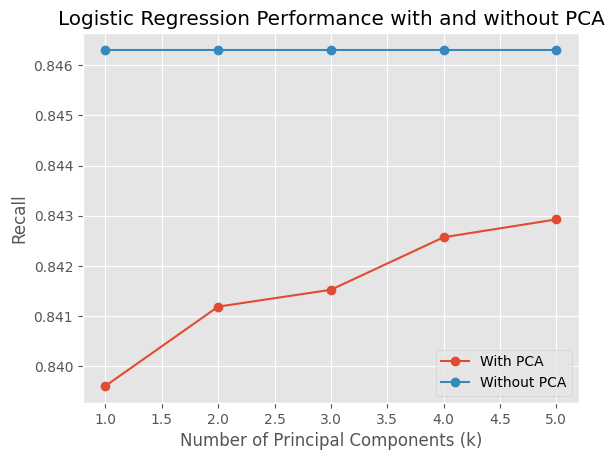

In [28]:
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# Define a range of values for k
k_values = [1, 2, 3, 4, 5]

# Lists to store F1 scores for PCA and non-PCA cases
weightedRecall_pca = []
weightedRecall_no_pca = []

# Train logistic regression model without PCA
train, test = dataset.randomSplit([0.8, 0.2], seed=12345)
lr_no_pca = LogisticRegression(labelCol="Diabetes", featuresCol="Scaled_features", maxIter=10)
model_lr_no_pca = lr_no_pca.fit(train)

for k in k_values:
    # Apply PCA with current k value
    pca = PCA(k=k, inputCol="Scaled_features", outputCol="pca_features")
    pca_model = pca.fit(dataset)
    dataset_pca = pca_model.transform(dataset)

    # Split dataset into train and test sets
    train_pca, test_pca = dataset_pca.randomSplit([0.8, 0.2], seed=12345)

    # Train logistic regression model with PCA
    lr_pca = LogisticRegression(labelCol="Diabetes", featuresCol="pca_features", maxIter=10)
    model_lr_pca = lr_pca.fit(train_pca)

    # Make predictions on test set with PCA
    predictions_test_pca = model_lr_pca.transform(test_pca)

    # Evaluate model with PCA
    evaluator_pca = MulticlassClassificationEvaluator(labelCol="Diabetes", predictionCol="prediction", metricName="weightedRecall")
    Recall_pca = evaluator_pca.evaluate(predictions_test_pca)
    weightedRecall_pca.append(Recall_pca)

    # Make predictions on test set without PCA
    predictions_test_no_pca = model_lr_no_pca.transform(test)

    # Evaluate model without PCA
    evaluator_no_pca = MulticlassClassificationEvaluator(labelCol="Diabetes", predictionCol="prediction", metricName="weightedRecall")
    Recall_no_pca = evaluator_no_pca.evaluate(predictions_test_no_pca)
    weightedRecall_no_pca.append(Recall_no_pca)

# Plot F1 scores for different k values
plt.plot(k_values, weightedRecall_pca, marker='o', label='With PCA')
plt.plot(k_values, weightedRecall_no_pca, marker='o', label='Without PCA')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Recall')
plt.title('Logistic Regression Performance with and without PCA')
plt.legend()
plt.grid(True)
plt.show()